In [8]:
import pandas as pd
import numpy as np
import pickle

from consts import PATH, RFM_PATH, MODEL_PATH

In [9]:
rfm = pd.read_parquet(RFM_PATH)
orig_data = pd.read_parquet(PATH)
model = pickle.load(open(MODEL_PATH, "rb"))

In [11]:
def conditional_probability_alive_matrix(
    model, data, max_frequency=None, max_recency=None
):

    max_frequency = max_frequency or int(data["frequency"].max())
    max_recency = max_recency or int(data["T"].max())

    return np.fromfunction(
        model.conditional_probability_alive,
        (max_frequency + 1, max_recency + 1),
        T=max_recency,
    ).T

In [12]:
def plot_probability_alive_matrix(
    model,
    conditional_probability_alive,
    max_frequency=None,
    max_recency=None,
    title="Probability Customer is Alive,\nby Frequency and Recency of a Customer",
    xlabel="Customer's Historical Frequency",
    ylabel="Customer's Recency",
    **kwargs
):

    from matplotlib import pyplot as plt

    z = conditional_probability_alive

    interpolation = kwargs.pop("interpolation", "none")

    ax = plt.subplot(111)
    pcm = ax.imshow(z, interpolation=interpolation, **kwargs)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    forceAspect(ax)

    plt.colorbar(pcm, ax=ax)

    return ax


def forceAspect(ax, aspect=1):
    im = ax.get_images()
    extent = im[0].get_extent()
    ax.set_aspect(abs((extent[1] - extent[0]) / (extent[3] - extent[2])) / aspect)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

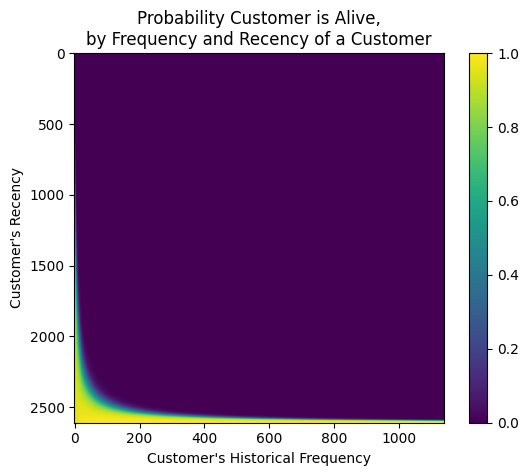

In [13]:
conditional_probability_alive = conditional_probability_alive_matrix(model, rfm)
plot_probability_alive_matrix(model, conditional_probability_alive)

In [14]:
from btyd.generate_data import beta_geometric_nbd_model
T = np.asarray(rfm["T"])
generate_new_data = lambda size=1: beta_geometric_nbd_model(
    T,
    np.mean(model.param_dict["data_vars"]["BetaGeoModel::r"]["data"]),
    np.mean(model.param_dict["data_vars"]["BetaGeoModel::alpha"]["data"]),
    np.mean(model.param_dict["data_vars"]["BetaGeoModel::a"]["data"]),
    np.mean(model.param_dict["data_vars"]["BetaGeoModel::b"]["data"]),
    size=size,
)

In [15]:
def plot_period_transactions(
    model,
    data,
    max_frequency=7,
    title="Frequency of Repeat Transactions",
    xlabel="Number of Calibration Period Transactions",
    ylabel="Customers",
    **kwargs
):
    
    from matplotlib import pyplot as plt

    labels = kwargs.pop("label", ["Actual", "Model"])

    n = data.shape[0]
    simulated_data = generate_new_data(size=n)

    model_counts = pd.DataFrame(data["frequency"].value_counts().sort_index().iloc[:max_frequency])
    simulated_counts = pd.DataFrame(simulated_data["frequency"].value_counts().sort_index().iloc[:max_frequency])
    combined_counts = model_counts.merge(simulated_counts, how="outer", left_index=True, right_index=True).fillna(0)
    combined_counts.columns = labels

    ax = combined_counts.plot(kind="bar", **kwargs)

    plt.legend()
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    return ax

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

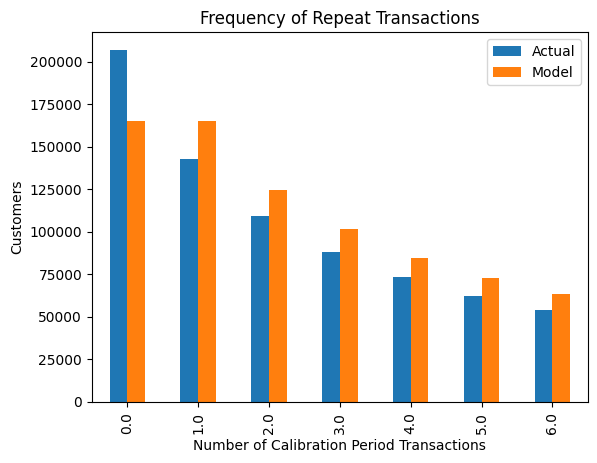

In [16]:
plot_period_transactions(model, rfm)

<Axes: title={'center': 'History of P_alive'}, ylabel='P_alive'>

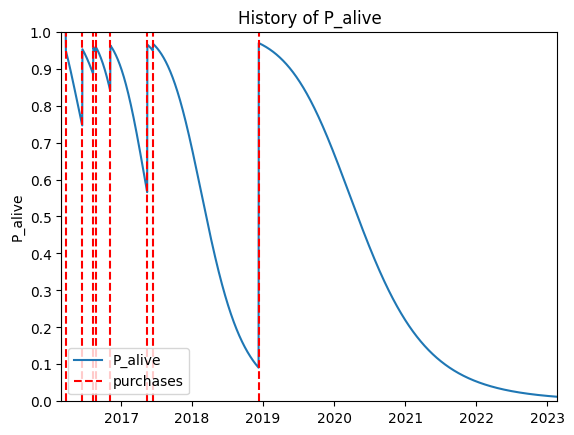

In [18]:
from btyd.plotting import plot_history_alive
dude = orig_data[orig_data["partner"]==5]
plot_history_alive(model, rfm.iloc[5]["T"], dude, "rep_date")

In [19]:
from btyd.utils import calculate_alive_path, expected_cumulative_transactions
import pandas as pd
import numpy as np
import pickle

from consts import PATH, RFM_PATH, MODEL_PATH

rfm = pd.read_parquet(RFM_PATH)
orig_data = pd.read_parquet(PATH)
model = pickle.load(open(MODEL_PATH, "rb"))

t = rfm.iloc[5]["T"]
transactions = orig_data[orig_data["partner"]==5]
datetime_col = "rep_date"
freq="D"
start_date=None
ax=None

customer_history = transactions[[datetime_col]].copy()
customer_history.index = pd.DatetimeIndex(customer_history[datetime_col])

# Add transactions column
customer_history["transactions"] = 1
customer_history = customer_history.resample(freq).sum()

# plot alive_path
path = calculate_alive_path(model, transactions, datetime_col, t, freq)
path_dates = pd.date_range(start=min(transactions[datetime_col]), periods=len(path), freq=freq)

In [21]:
path

0                        [1.0]
1                        [1.0]
2                        [1.0]
3                        [1.0]
4                        [1.0]
                 ...          
2547     [0.01234280084721397]
2548    [0.012301966094719216]
2549    [0.012261280602218391]
2550    [0.012220743777340492]
2551     [0.01218035503021782]
Length: 2552, dtype: object

In [22]:
path_dates

DatetimeIndex(['2016-02-29', '2016-03-01', '2016-03-02', '2016-03-03',
               '2016-03-04', '2016-03-05', '2016-03-06', '2016-03-07',
               '2016-03-08', '2016-03-09',
               ...
               '2023-02-14', '2023-02-15', '2023-02-16', '2023-02-17',
               '2023-02-18', '2023-02-19', '2023-02-20', '2023-02-21',
               '2023-02-22', '2023-02-23'],
              dtype='datetime64[ns]', length=2552, freq='D')